# PRJ-002: Diabetes 130-US Hospitals for Years 1999-2008 

In [587]:
admission_type_id={1:"Emergency", 2:"Urgent", 3:"Elective",4:"Newborn",5:"Not Available",6:"NULL",7:"Not Mapped"}

discharge_disposition_id = {
    1: "Discharged to home",
    2: "Discharged/transferred to another short term hospital",
    3: "Discharged/transferred to SNF",
    4: "Discharged/transferred to ICF",
    5: "Discharged/transferred to another type of inpatient care institution",
    6: "Discharged/transferred to home with home health service",
    7: "Left AMA",
    8: "Discharged/transferred to home under care of Home IV provider",
    9: "Admitted as an inpatient to this hospital",
    10: "Neonate discharged to another hospital for neonatal aftercare",
    11: "Expired",
    12: "Still patient or expected to return for outpatient services",
    13: "Hospice / home",
    14: "Hospice / medical facility",
    15: "Discharged/transferred within this institution to Medicare approved swing bed",
    16: "Discharged/transferred/referred another institution for outpatient services",
    17: "Discharged/transferred/referred to this institution for outpatient services",
    18: "NULL",
    19: "Expired at home. Medicaid only, hospice.",
    20: "Expired in a medical facility. Medicaid only, hospice.",
    21: "Expired, place unknown. Medicaid only, hospice.",
    22: "Discharged/transferred to another rehab fac including rehab units of a hospital",
    23: "Discharged/transferred to a long term care hospital",
    24: "Discharged/transferred to a nursing facility certified under Medicaid but not certified under Medicare.",
    25: "Not Mapped",
    26: "Unknown/Invalid",
    30: "Discharged/transferred to another Type of Health Care Institution not Defined Elsewhere",
    27: "Discharged/transferred to a federal health care facility.",
    28: "Discharged/transferred/referred to a psychiatric hospital or psychiatric distinct part unit of a hospital",
    29: "Discharged/transferred to a Critical Access Hospital (CAH)."
}

admission_source_id = {
    1: "Physician Referral",
    2: "Clinic Referral",
    3: "HMO Referral",
    4: "Transfer from a hospital",
    5: "Transfer from a Skilled Nursing Facility (SNF)",
    6: "Transfer from another health care facility",
    7: "Emergency Room",
    8: "Court/Law Enforcement",
    9: "Not Available",
    10: "Transfer from critical access hospital",
    11: "Normal Delivery",
    12: "Premature Delivery",
    13: "Sick Baby",
    14: "Extramural Birth",
    15: "Not Available",
    17: "NULL",
    18: "Transfer From Another Home Health Agency",
    19: "Readmission to Same Home Health Agency",
    20: "Not Mapped",
    21: "Unknown/Invalid",
    22: "Transfer from hospital inpt/same fac reslt in a sep claim",
    23: "Born inside this hospital",
    24: "Born outside this hospital",
    25: "Transfer from Ambulatory Surgery Center",
    26: "Transfer from Hospice"
}

## Imports
Copied from previous project to have a foundation. We can delete unused ones later.

In [588]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import gaussian_kde
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

## Import dataset and print basic info

In [589]:
data = pd.read_csv("diabetic_data.csv")

## Preprocess Data

In [590]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

All rows seem to have no null values but it is incorrect. The null values are defined with a question mark. 

### Remove Duplicates

There are several duplicates in the dataset. Which can be seen when looking at the dataset and ordering by 'patient_nbr' from lowest to highest.

In [591]:
data = data.drop_duplicates(subset=['patient_nbr'])

### Handle missing values
Some of the features are missing many values to make a significant difference and some are not useful e.g. 'patient_nbr'

Below are plots showing how many percent of the features are NaN

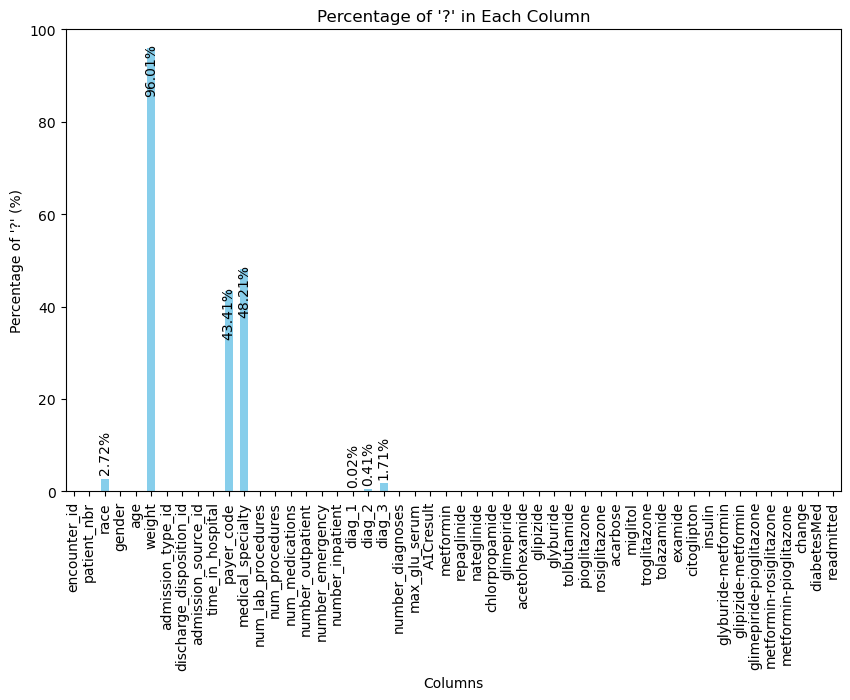

In [592]:
total_counts = data.shape[0]

# Calculate the number of ? values in each column
question_mark_counts = data.apply(lambda col: col.astype(str).str.count(r'\?').sum())

question_mark_percentage = (question_mark_counts / total_counts) * 100

plt.figure(figsize=(10, 6))
question_mark_percentage.plot(kind='bar', color='skyblue')
plt.title("Percentage of '?' in Each Column")
plt.xlabel("Columns")
plt.ylabel("Percentage of '?' (%)")
plt.ylim(0, 100)  # Set y-axis from 0 to 100% for clarity
plt.xticks(rotation=90)

# Add percentage labels on top of each bar
for idx, value in enumerate(question_mark_percentage):
    if(value>0):
        plt.text(idx, value + 1, f'{value:.2f}%', ha='center', va=('top' if value>10 else 'bottom'), fontsize=10, rotation=90)

plt.show()

Some of features contain many values that are the same e.g. most of the drug features.

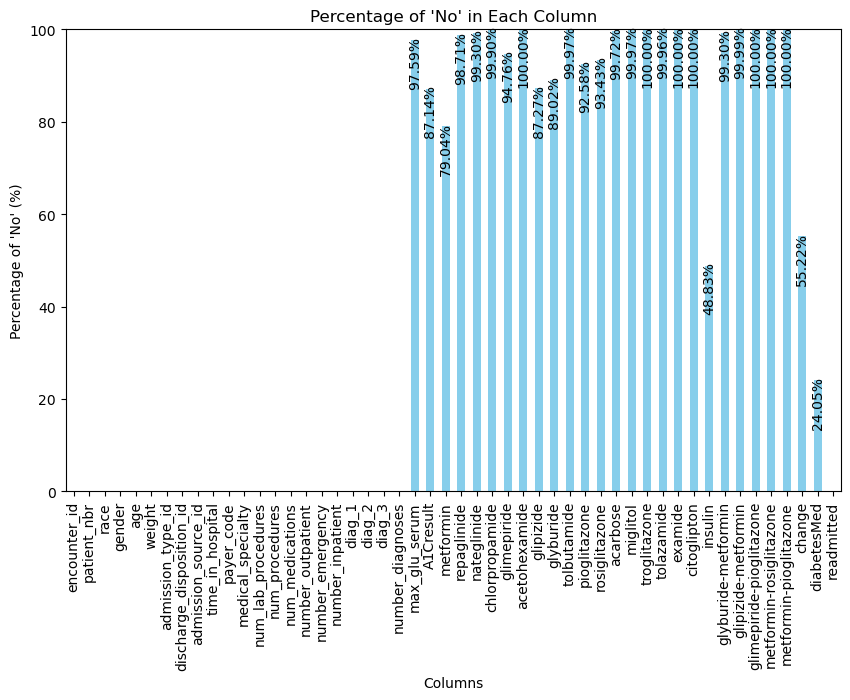

In [593]:
# Calculate the number of NaN values in each column
no_counts = data.apply(lambda col: col.astype(str).str.count('No').sum())

no_percentage = (no_counts / total_counts) * 100

plt.figure(figsize=(10, 6))
no_percentage.plot(kind='bar', color='skyblue')
plt.title("Percentage of 'No' in Each Column")
plt.xlabel("Columns")
plt.ylabel("Percentage of 'No' (%)")
plt.ylim(0, 100)  # Set y-axis from 0 to 100% for clarity
plt.xticks(rotation=90)

# Add percentage labels on top of each bar
for idx, value in enumerate(no_percentage):
    if(value>1):
        plt.text(idx, value + 1, f'{value:.2f}%', ha='center', va=('top' if value>10 else 'bottom'), fontsize=10, rotation=90)


plt.show()

Feature that are not useful:

|Feature|Explanation|
|---|---|
|encounter_id| Is unique|
|patient_nbr|Is unique|
|weight|Over 95 % missing values|
|repaglinide|Over 95 % does not take this drug|
|nateglinide|Over 95 % does not take this drug|
|chlorpropamide|Over 95 % does not take this drug|
|acetohexamide|Same values for all rows|
|tolbutamide|Over 95 % does not take this drug|
|acarbose|Over 95 % does not take this drug|
|miglitol|Over 95 % does not take this drug|
|troglitazone|Same values for all rows|
|tolazamide|Over 95 % does not take this drug|
|examide|Same values for all rows|
|citoglipton|Same values for all rows|
|glyburide-metformin|Over 95 % does not take this drug|
|glipizide-metformin|Over 95 % does not take this drug|
|glimepiride-pioglitazone|Same values for all rows|
|metformin-rosiglitazone|Same values for all rows|
|metformin-pioglitazone|Same values for all rows|


In [594]:
columns_to_drop=['weight','patient_nbr','encounter_id',
                 'repaglinide','nateglinide','chlorpropamide',
                 'acetohexamide','tolbutamide','acarbose','miglitol',
                 'troglitazone','tolazamide','examide', 'citoglipton',
                 'glyburide-metformin','glipizide-metformin',
                 'glimepiride-pioglitazone','metformin-rosiglitazone',
                 'metformin-pioglitazone']

data.drop(columns=columns_to_drop,  inplace=True)

# Many missing values, but potentially high relevance
data['medical_specialty'].fillna('Unknown', inplace=True)

# Few missing values
data['race'].fillna('Unknown', inplace=True)
data['diag_1'].fillna('Unknown', inplace=True)
data['diag_2'].fillna('Unknown', inplace=True)
data['diag_3'].fillna('Unknown', inplace=True)

# Remove 3 rows where gender is "Unknown/Invalid"
data = data[data['gender'] != 'Unknown/Invalid']

#Replace '?' with other
data.replace('?', 'Other', inplace=True)

### Encoding

Encode Binary columns

In [595]:
data['gender'] = data['gender'].map({'Male': 1, 'Female': 0}).astype('int64')
data['change'] = data['change'].map({'Ch': 1, 'No': 0}).astype('int64')
data['diabetesMed'] = data['diabetesMed'].map({'Yes': 1, 'No': 0}).astype('int64')


Encode all medicine

In [597]:
# Numeric mapping for medication columns
medication_columns = ['metformin','glimepiride','glipizide', 'glyburide','pioglitazone','rosiglitazone', 'insulin']

data[medication_columns] = data[medication_columns].replace({'Steady': 1, 'No': 0, 'Down': -1, 'Up': 2})


Encode the categorical columns

In [599]:
categorical_colums=['race','payer_code','medical_specialty',]

# One-Hot Encoding for categorical columns
data = pd.get_dummies(data, columns=categorical_colums, drop_first=True)


Encode Ordinal columns

In [601]:

data['age'] = data['age'].map({'[0-10)':0, '[10-20)':1, '[20-30)':2, '[30-40)':3, '[40-50)':4, '[50-60)':5, '[60-70)':6, '[70-80)':7, '[80-90)':8, '[90-100)':9}).astype('int64')

data['readmitted'] = data['readmitted'].map({'NO': 0, '<30': 1,'>30':2}).astype('int64')

data['max_glu_serum'] = data['max_glu_serum'].map({'None': 0, 'Norm': 1,'>200':2,'>300':3}).astype('int64')

A1Cresult=[['None','Norm','>7','>8']]
data['A1Cresult'] = data['A1Cresult'].map({'None': 0, 'Norm': 1,'>7':2,'>8':3}).astype('int64')


Encode the diagnoses

The diagnoses are encoded with ICD-9. https://en.wikipedia.org/wiki/List_of_ICD-9_codes
This means we can categorize them into 19 categories to simplify the data. E and V being divided into 2 categories instead of one.

In [602]:
def map_diag(value):
    if isinstance(value,str) and (value.startswith('E') or value.startswith('V') or value.startswith('O')):
        if value.startswith('E'):
            return 17
        elif value.startswith('V'):
            return 18
        elif value.startswith('O'): #When its other
            return -1
    else:
        value=float(value)
        if value <= 139:
            return 0
        elif 140 <= value <= 239:
            return 1
        elif 240 <= value <= 279:
            return 2
        elif 280 <= value <= 289:
            return 3
        elif 290 <= value <= 319:
            return 4
        elif 320 <= value <= 389:
            return 5
        elif 390 <= value <= 459:
            return 6
        elif 460 <= value <= 519:
            return 7
        elif 520 <= value <= 579:
            return 8
        elif 580 <= value <= 629:
            return 9
        elif 630 <= value <= 679:
            return 10
        elif 680 <= value <= 709:
            return 11
        elif 710 <= value <= 739:
            return 12
        elif 740 <= value <= 759:
            return 13
        elif 760 <= value <= 779:
            return 14
        elif 780 <= value <= 799:
            return 15
        elif 800 <= value <= 999:
            return 16

data['diag_1']= data['diag_1'].apply(map_diag) 
data['diag_2']= data['diag_2'].apply(map_diag) 
data['diag_3']= data['diag_3'].apply(map_diag) 

In [603]:
#Check if it worked
data['diag_1'].unique()

array([ 2, 10,  0,  1,  6,  7, 16, 11, 12,  8, 18, 15,  9,  4,  5,  3, -1,
       13, 17], dtype=int64)

### Splitting

In [604]:
# Split into features and target
X = data.drop('readmitted', axis=1)
y = data['readmitted']

# Split into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Scaling

In [612]:
scaler = StandardScaler()
numerical_features = ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient']
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

In [613]:
# Testing for missing values, troubleshooting
print("Missing values in X_train:", X_train.isnull().sum().sum())

Missing values in X_train: 0


## Model choice
We decided to start with two classification and one clustering algorithm.
### Logistic Regression
- Effective for rougly linear relationships
- Interpretable (giving us an idea of the meaning of each feature)
- Efficient for large datasets
### Random Forest
- Captures complex, non-linear relationships (good counterpart to Logisitc Regression)
- Allows determining feature importance
- Usually performs well without hypertuning
### K-Means Clustering
- Easy to interpret
- Effective for grouping patients with similar characteristics
- Might still be fast enough for a dataset of our size
- There are different ways to make K-Means faster, if needed.

## Model implementation

### Functions

In [614]:

def plot_feature_importances(model, top_n=None):
    """
    Plots the feature importances of a model.

    Parameters:
    - model: A trained model with a `feature_importances_` attribute (e.g., tree-based models).
    - X_train: Training data as a DataFrame (to automatically retrieve feature names).
    - top_n: Integer specifying the number of top features to plot. If None, all features are plotted.

    """
    # Retrieve feature importances from the model
    importances = model.feature_importances_
    
    # Determine feature names from X_train if provided, otherwise use generic names
    
    feature_names = X_train.columns
    
    
    # Combine feature names and their importance scores
    feature_importance_pairs = list(zip(feature_names, importances))
    
    # Sort features by importance
    feature_importance_pairs = sorted(feature_importance_pairs, key=lambda x: x[1], reverse=True)
    
    # If specified, select only the top_n features
    if top_n is not None:
        feature_importance_pairs = feature_importance_pairs[:top_n]
    
    # Separate the feature names and their scores after sorting
    features, importance_scores = zip(*feature_importance_pairs)
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.barh(features, importance_scores, color="skyblue")
    plt.xlabel("Feature Importance")
    plt.ylabel("Features")
    plt.title("Feature Importances")
    plt.gca().invert_yaxis()  # Invert y-axis to have the highest importance at the top
    plt.show()


### Logistic Regression

In [615]:
# Initialize
log_reg = LogisticRegression(max_iter=1000, random_state=42)

# train
log_reg.fit(X_train, y_train)

# Predict
y_pred_log_reg = log_reg.predict(X_test)

# Evaluate
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_log_reg))
print(classification_report(y_test, y_pred_log_reg))
print(confusion_matrix(y_test, y_pred_log_reg))

Logistic Regression Accuracy: 0.6185415647067048
              precision    recall  f1-score   support

           0       0.63      0.95      0.76      8757
           1       0.33      0.00      0.00      1225
           2       0.47      0.12      0.19      4321

    accuracy                           0.62     14303
   macro avg       0.48      0.36      0.32     14303
weighted avg       0.56      0.62      0.52     14303

[[8341    4  412]
 [1062    3  160]
 [3816    2  503]]


c:\Users\alexa\anaconda3\envs\Seminar2\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


### Random forest

In [616]:
# Assuming you have a DataFrame X for features and y for labels
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

rfc_y_pred = rfc.predict(X_test)


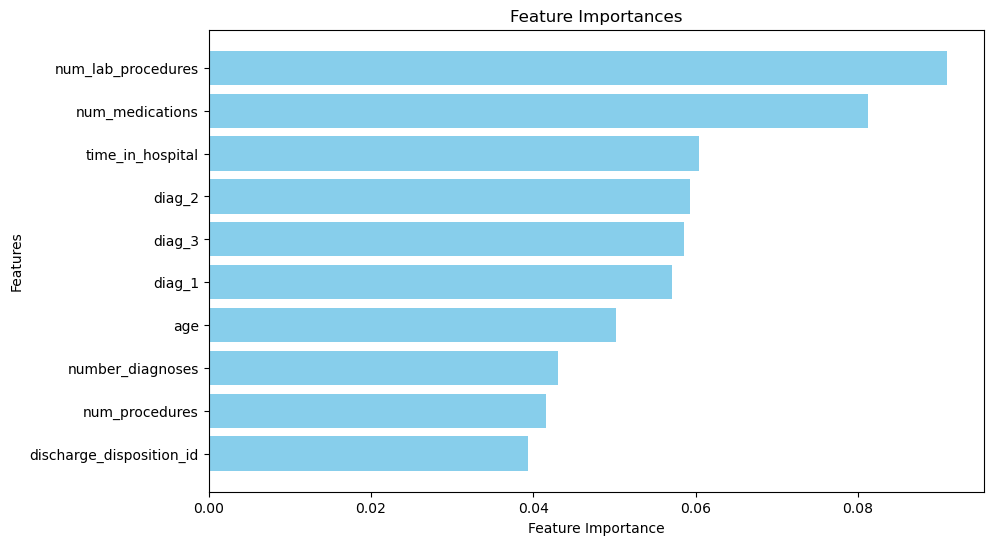

In [617]:
plot_feature_importances(rfc,10)

In [618]:

# Evaluate

print("Logistic Regression Accuracy:", accuracy_score(y_test,rfc_y_pred))
print(classification_report(y_test, rfc_y_pred))
print(confusion_matrix(y_test, rfc_y_pred))

Logistic Regression Accuracy: 0.6226665734461302
              precision    recall  f1-score   support

           0       0.64      0.92      0.76      8757
           1       0.50      0.00      0.00      1225
           2       0.48      0.20      0.28      4321

    accuracy                           0.62     14303
   macro avg       0.54      0.37      0.35     14303
weighted avg       0.58      0.62      0.55     14303

[[8047    2  708]
 [1010    3  212]
 [3464    1  856]]
